In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import mlab
from scipy import signal
import h5py, time
import sys
import glob
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [3]:
def get_force_from_discharge(folder,file_list,axis,drive_freq=151):
    ret_value = []
    for i in file_list:
        fname = folder+"/Bead"+str(BeadNumber)+"/Discharge"+"/Discharge_%d.h5" %i
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        fsamp=5000
        res=50000
        data_det=signal.detrend(data)     
        xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        if(str(axis)=="x"):
            ret_value.append(np.sqrt(xpsd[drive_freq*10]))
        if(str(axis)=="y"):
            ret_value.append(np.sqrt(ypsd[drive_freq*10]))
        if(str(axis)=="z"):
            ret_value.append(np.sqrt(zpsd[drive_freq*10]))
    return ret_value

def force_conversion_factor(q,V=10,conv_factor=0.65,electrode_distance=8.6e-3):
    F=(q*1.602e-19)*(V*2/electrode_distance*conv_factor)
    return F 


def bit_to_force_conversion_factor(file_list,axis,q,V=10):
    bit_normal = np.mean(get_force_from_discharge(folder,file_list,axis))
    force=force_conversion_factor(q,V)
    bit_to_force = force/bit_normal
    return bit_to_force

In [4]:
# Force calibration using transfer function

def transfer_func_prep(folder,axis,base_freq=7):
    # get the file name with the convention Akio has chosen
    res=50000
    fsamp= 5000
    if(axis=="X"):
        x_list =[]
        number = 1
        fname = folder+"/Bead"+str(BeadNumber)+"/TransFunc"+"/Transfunc%s_%d.h5" %(axis,number)
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        data_det=signal.detrend(data)
        Xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        
        x_list.append(np.sqrt(Xpsd[base_freq*10])) 
        x_list.append(np.sqrt(Xpsd)) 
        x_list.append(np.sqrt(Ypsd)) 
        x_list.append(np.sqrt(Zpsd))
        #print("Returning list with Noise at base frequency,XNoise,YNoise,ZNoise")
        return x_list
    if(axis=="Y"):
        y_list =[]
        number = 2
        fname = folder+"/Bead"+str(BeadNumber)+"/TransFunc"+"/Transfunc%s_%d.h5" %(axis,number)
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        data_det=signal.detrend(data)
        Xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        y_list.append(np.sqrt(Ypsd[base_freq*10])) 
        y_list.append(np.sqrt(Xpsd)) 
        y_list.append(np.sqrt(Ypsd)) 
        y_list.append(np.sqrt(Zpsd))
        #print("Returning list with Noise at base frequency,XNoise,YNoise,ZNoise")
        return y_list
    if(axis=="Z"):
        z_list =[]
        number = 3
        fname = folder+"/Bead"+str(BeadNumber)+"/TransFunc"+"/Transfunc%s_%d.h5" %(axis,number)
        BDF = BeadDataFile.BeadDataFile(fname)
        data = BDF.xyz2
        data_det=signal.detrend(data)
        Xpsd, freqs = matplotlib.mlab.psd(data_det[0], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Ypsd, freqs = matplotlib.mlab.psd(data_det[1], Fs = fsamp, NFFT = res,window=mlab.window_none)
        Zpsd, freqs = matplotlib.mlab.psd(data_det[2], Fs = fsamp, NFFT = res,window=mlab.window_none)
        z_list.append(np.sqrt(Zpsd[base_freq*10])) 
        z_list.append(np.sqrt(Xpsd)) 
        z_list.append(np.sqrt(Ypsd)) 
        z_list.append(np.sqrt(Zpsd))
        #print("Returning list with Noise at base frequency,XNoise,YNoise,ZNoise")
        return z_list


In [5]:
def transfer_func_output(folder,q,V,base_freq=7,no_harmonics=100):
    x_list = transfer_func_prep(folder,"X",base_freq=base_freq)
    y_list = transfer_func_prep(folder,"Y",base_freq=base_freq)
    z_list = transfer_func_prep(folder,"Z",base_freq=base_freq)
    F = force_conversion_factor(q,V)
    
    force_noise_in_x = []
    force_noise_in_x.append(x_list[1]/x_list[0]*F)
    force_noise_in_x.append(x_list[2]/y_list[0]*F)
    force_noise_in_x.append(x_list[3]/z_list[0]*F)
    force_noise_in_y = []
    force_noise_in_y.append(y_list[1]/x_list[0]*F)
    force_noise_in_y.append(y_list[2]/y_list[0]*F)
    force_noise_in_y.append(y_list[3]/z_list[0]*F)  
    force_noise_in_z = []
    force_noise_in_z.append(z_list[1]/x_list[0]*F)
    force_noise_in_z.append(z_list[2]/y_list[0]*F)
    force_noise_in_z.append(z_list[3]/z_list[0]*F)   
    
    TFXX=[]
    TFXY=[]
    TFXZ=[]
    TFYX=[]
    TFYY=[]
    TFYZ=[]
    TFZX=[]
    TFZY=[]
    TFZZ=[]
    
    FreqTF = np.arange(base_freq,(base_freq*no_harmonics+base_freq),base_freq)
    for i in range(no_harmonics):
        TFXX.append(force_noise_in_x[0][base_freq*10*(i+1)])
        TFXY.append(force_noise_in_x[1][base_freq*10*(i+1)])
        TFXZ.append(force_noise_in_x[2][base_freq*10*(i+1)])
        TFYX.append(force_noise_in_y[0][base_freq*10*(i+1)])
        TFYY.append(force_noise_in_y[1][base_freq*10*(i+1)])
        TFYZ.append(force_noise_in_y[2][base_freq*10*(i+1)])
        TFZX.append(force_noise_in_z[0][base_freq*10*(i+1)])
        TFZY.append(force_noise_in_z[1][base_freq*10*(i+1)])
        TFZZ.append(force_noise_in_z[2][base_freq*10*(i+1)])
                    
    TFX = [TFXX,TFXY,TFXZ]
    TFY = [TFYX,TFYY,TFYZ]
    TFZ = [TFZX,TFZY,TFZZ]
    TF = [TFX,TFY,TFZ]                
    return FreqTF,TF    

In [6]:
def transfer_function1(data_x,params=list):
    # for normalization a 1/sigma could be needed
    return params[0]*params[1]**2/np.sqrt((data_x*data_x-params[1]**2)**2+params[2]**2*data_x**2)+params[3]

def chisquare_1d(function, data_x, data_y,data_y_error, functionparams=list):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_tf(a,b,c,d):
    return chisquare_1d(function=transfer_function1,functionparams=[a,b,c,d],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

def two_dimensional_gaussian(data_x,data_y,params=list):
    #g1 = ((data_x-params[1])/params[2]);
    #g2 = ((data_x-params[2])/params[4]);   
    return params[0]*np.exp(-0.5*(np.power((((data_x-params[1])*np.cos(params[3])-(data_y-params[2])*np.sin(params[3]))/params[4]),2)+np.power((((data_x-params[1])*np.sin(params[3])+(data_y-params[2])*np.cos(params[3]))/params[5]),2)))+params[6]
              


In [7]:
def transfer_function_fits(FreqTF,TF,fix_d=False,base_freq=7):
    parameter_list = []
    for i in np.arange(0,3,1):
        def chisquare_tf(a,b,c,d):
            return chisquare_1d(function=transfer_function1,functionparams=[a,b,c,d],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
        data_x = np.asarray(FreqTF)
        data_y=np.asarray(TF[i][i])
        data_y_error=data_y/10
        m2=Minuit(chisquare_tf,a=1e-16,fix_a=False,b=415,fix_b=False,c=2,fix_c=False,d=0,fix_d=fix_d,errordef = 1,print_level=1)
        m2.migrad(ncall=500000)
        var_list=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]
        parameter_list.append(var_list)
        plt.title("%s" %i)
        plt.plot(FreqTF,transfer_function1(data_x,params=[m2.values["a"],m2.values["b"],m2.values["c"],m2.values["d"]]))
        plt.plot(FreqTF,TF[i][i])
        plt.yscale("log")
        plt.show()
    return parameter_list    

In [8]:
def from_data_to_force_amp_and_phase_per_harmonic(folder,data_set_list,file_list,q,V=10,shake_freq=13,no_harmonics=100,drive_freq=151,base_freq=7,no_harmonics_tf=100):
        FreqTF,TF = transfer_func_output(folder,q,V,no_harmonics=no_harmonics_tf)
        TF_val = transfer_function_fits(FreqTF,TF)
        file_amp_list = []
        file_phase_list = []
        for data_set in tqdm(data_set_list):
            fname = data_set#folder+"/Bead"+str(BeadNumber)+"/Shaking"+"/Shaking%d_%d.h5" % (data_set,0)
            BDF = BeadDataFile.BeadDataFile(fname)
            data = BDF.xyz2
            res = 50000
            fsamp=5000
            data_det=signal.detrend(data)
            freqs=np.linspace(0,2500,(res/2)+1)    # change
            xFFT=np.fft.rfft(data_det[0])
            yFFT=np.fft.rfft(data_det[1])
            zFFT=np.fft.rfft(data_det[2])
            norm = np.sqrt(2 / (res* fsamp))
            xpsd = norm**2 * (xFFT * xFFT.conj()).real
            ypsd = norm**2 * (yFFT * yFFT.conj()).real
            zpsd = norm**2 * (zFFT * zFFT.conj()).real

            w0x=TF_val[0][1]
            gx=TF_val[0][2]
            w0y=TF_val[1][1]
            gy=TF_val[1][2]
            w0z=TF_val[2][1]
            gz=TF_val[2][2]
            BtoFx=bit_to_force_conversion_factor(file_list[0],"x",q,V)#3.14E-12
            BtoFy=bit_to_force_conversion_factor(file_list[1],"y",q,V)#1.57E-12
            BtoFz=bit_to_force_conversion_factor(file_list[2],"z",q,V)#2.71E-19
            const_x = TF_val[0][3]
            const_y = TF_val[1][3]
            const_z = TF_val[2][3]

            f0=drive_freq
            F0x=1/(np.sqrt((f0**2-w0x**2)**2+gx**2*f0**2)+const_x)
            F0y=1/(np.sqrt((f0**2-w0y**2)**2+gy**2*f0**2)+const_y)
            F0z=1/(np.sqrt((f0**2-w0z**2)**2+gz**2*f0**2)+const_z)

            xnsd=np.sqrt(xpsd)*BtoFx*F0x*(np.sqrt((freqs**2-w0x**2)**2+gx**2*freqs**2)+const_x)
            ynsd=np.sqrt(ypsd)*BtoFy*F0y*(np.sqrt((freqs**2-w0y**2)**2+gy**2*freqs**2)+const_y)
            znsd=np.sqrt(zpsd)*BtoFz*F0z*(np.sqrt((f0**2-w0z**2)**2+gz**2*f0**2)+const_z)

            xphase=np.angle(xFFT)
            yphase=np.angle(yFFT)
            zphase=np.angle(zFFT)

            # now get amplitude and phase from all harmonics

            no_harmonics=np.arange(1,100,1)
            norm_factor = 10
            frequency=13
            response_amp=[]
            response_phase = []
            for i in no_harmonics:
                a = xnsd[i*shake_freq*norm_factor] * np.cos(xphase[i*shake_freq*norm_factor]) 
                b = xnsd[i*shake_freq*norm_factor] * np.sin(xphase[i*shake_freq*norm_factor])
                response_amp.append(a)
                response_phase.append(b)
            file_amp_list.append(response_amp)
            file_phase_list.append(response_phase)
        return file_amp_list,file_phase_list
        

In [11]:
foldername = r'/data/new_trap/20191215/Bead1/Discharge/'

resp_z = discharge_response(foldername=foldername,str_axis='z',drive_freq=151)
resp_x = discharge_response(foldername=foldername,str_axis='x',drive_freq=151)
resp_y = discharge_response(foldername=foldername,str_axis='y',drive_freq=151)

419  files in folder
419  files loaded


/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


419  files in folder
419  files loaded
419  files in folder
419  files loaded


In [87]:
responses = [resp_z[29:-1]/np.mean(resp_z[374:379]),resp_y[29:-1]/np.mean(resp_y[379:384]),resp_x[29:-1]/np.mean(resp_x[369:374])]

In [101]:
reshape_responses = np.reshape(responses, (3, 389)).T

In [149]:
discharge_axis_list = []
plot_driven_response_x, plot_driven_response_y, plot_driven_response_z=([] for i in range(3))
x_list, y_list, z_list = ([] for i in range(3))
for j in range(len(reshape_responses)):
    discharge_axis_list.append(np.argmax(reshape_responses[j]))
    if(np.argmax(reshape_responses[j])==2):
        x_list.append(j)
        plot_driven_response_x.append(reshape_responses[j][discharge_axis_list[j]])
    if(np.argmax(reshape_responses[j])==1):
        y_list.append(j)
        plot_driven_response_y.append(reshape_responses[j][discharge_axis_list[j]])
    if(np.argmax(reshape_responses[j])==0):
        z_list.append(j)
        plot_driven_response_z.append(reshape_responses[j][discharge_axis_list[j]])


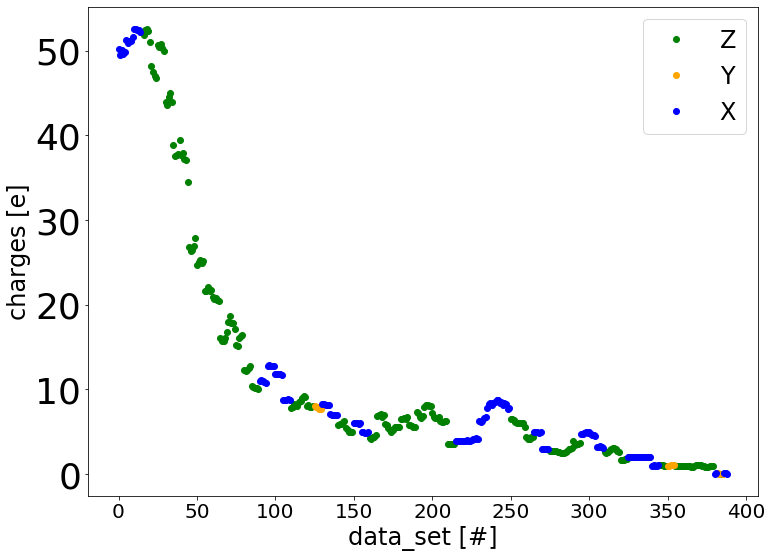

In [184]:
plt.plot(z_list,plot_driven_response_z, linestyle = "", marker ="o", color = "green", label = "Z")
plt.plot(y_list,plot_driven_response_y, linestyle = "", marker ="o", color = "orange", label ="Y")
plt.plot(x_list,plot_driven_response_x, linestyle = "", marker ="o", color = "blue", label = "X")
plt.ylabel("charges [e]")
plt.xlabel("data_set [#]")
plt.savefig("Results/Dalen_20200106/discharge/overview_discharge.png", dpi=300,bbox_inches="tight")

plt.legend()
plt.show()

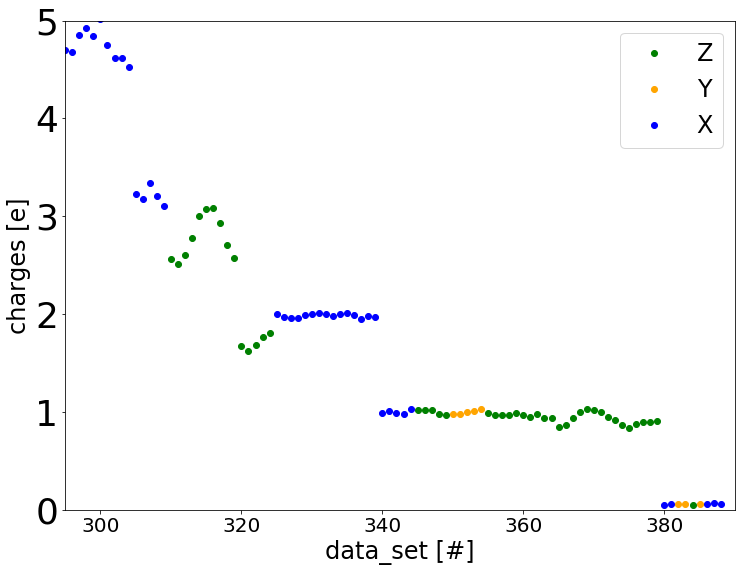

In [183]:
plt.plot(z_list,plot_driven_response_z, linestyle = "", marker ="o", color = "green", label = "Z")
plt.plot(y_list,plot_driven_response_y, linestyle = "", marker ="o", color = "orange", label ="Y")
plt.plot(x_list,plot_driven_response_x, linestyle = "", marker ="o", color = "blue", label = "X")
plt.ylabel("charges [e]")
plt.xlabel("data_set [#]")
plt.xlim(295,390)
plt.ylim(0,5)
plt.legend()
plt.savefig("Results/Dalen_20200106/discharge/discharge.png", dpi=300,bbox_inches="tight")
plt.show()

In [190]:
Year = "2019"
Month = "12"
Day = "15"
BeadNumber =1
folder = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day
file_list =  range(369,374)
axis = "x"
#b_to_f = get_force_from_discharge(folder,file_list,axis,drive_freq=151)

In [194]:
b_to_f = bit_to_force_conversion_factor(file_list,axis,q=1,V=10)


In [195]:
b_to_f

9.242334036366173e-13